# 自动编码器
自动编码器最开始是作为一种数据压缩方法，同时还可以在卷积网络中进行逐层预训练，但是随后更多结构复杂的网络，比如 resnet 的出现使得我们能够训练任意深度的网络，自动编码器就不再使用在这个方面，下面我们讲一讲自动编码器的一个新的应用，这是随着生成对抗模型而出现的，就是使用自动编码器生成数据。

自动编码器的一般结构如下

![](https://ws1.sinaimg.cn/large/006tNc79ly1fmzr05igw3j30ni06j3z4.jpg)

由上面的图片，我们能够看到，第一部分是编码器(encoder)，第二部分是解码器(decoder)，编码器和解码器都可以是任意的模型，通常我们可以使用神经网络作为我们的编码器和解码器，输入的数据经过神经网络降维到一个编码，然后又通过另外一个神经网络解码得到一个与原始数据一模一样的生成数据，通过比较原始数据和生成数据，希望他们尽可能接近，所以最小化他们之间的差异来训练网络中编码器和解码器的参数。

当训练完成之后，我们如何生成数据呢？非常简单，我们只需要拿出解码器的部分，然后随机传入 code，就可以通过解码器生成各种各样的数据

![](https://ws3.sinaimg.cn/large/006tNc79ly1fmzrx3d3ygj30nu06ijs2.jpg)

下面我们使用 mnist 数据集来说明一个如何构建一个简单的自动编码器

In [1]:
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

import numpy as np

import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.examples.tutorials.mnist.input_data as input_data

tf.set_random_seed(2017)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = input_data.read_data_sets('MNIST_data')
train_set = mnist.train
test_set = mnist.test

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
def autoencoder(inputs, scope='autoencoder', reuse=None):
    with tf.variable_scope(scope, reuse=reuse):
        with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.relu):
            with tf.variable_scope('encoder'):
                encode = slim.fully_connected(inputs, 128, scope='fc1')
                encode = slim.fully_connected(encode, 64, scope='fc2')
                encode = slim.fully_connected(encode, 12, scope='fc3')
                encode = slim.fully_connected(encode, 3, activation_fn=None, scope='fc4')
            with tf.variable_scope('decoder'):
                decode = slim.fully_connected(encode, 12, scope='fc1')
                decode = slim.fully_connected(decode, 64, scope='fc2')
                decode = slim.fully_connected(decode, 128, scope='fc3')
                decode = slim.fully_connected(decode, 28 * 28, activation_fn=tf.tanh, scope='fc4')
            return encode, decode

这里定义的编码器和解码器都是 4 层神经网络作为模型，中间使用`relu`激活函数，最后输出的 code 是三维，注意解码器最后我们使用`tanh`作为激活函数，因为输入图片标准化在 -1 ~ 1 之间，所以输出也要在 -1 ~ 1 这个范围内，最后我们可以验证一下

In [4]:
input_ph = tf.placeholder(tf.float32, shape=[None, 784])
inputs = tf.divide(input_ph - 0.5, 0.5)
code, output = autoencoder(inputs)
print(code.shape)
print(output.shape)

(?, 3)
(?, 784)


In [5]:
loss= tf.losses.mean_squared_error(inputs, output)
opt = tf.train.AdamOptimizer(1e-3)
train_op = opt.minimize(loss)

- **`tf.summary.image`**

我们可以给`tensorboard`添加图像元素, 来观察解码的效果是如何变化的

`tf.summary.image`的参数是一个4维的张量, 最后一维的大小必须是1, 3, 4中的一个

In [6]:
# 将输入重新reshape成图片形式
gt = tf.reshape(input_ph, (-1, 28, 28, 1))

# 重新reshape解码结果并变换回到[0, 1]区间
pre = tf.reshape(output, (-1, 28, 28, 1)) * 0.5 + 0.5

# 我们把原图和解码结果并排放在一起显示
images = tf.concat([gt, pre], axis=2)[:3]

# 添加`summary`
images_sum = tf.summary.image('images', images)

In [7]:
sess = tf.Session()

添加`summary`

In [8]:
sess.run(tf.global_variables_initializer())

train_writer = tf.summary.FileWriter('simple_autoencoder/train', sess.graph)
val_writer = tf.summary.FileWriter('simple_autoencoder/val', sess.graph)

In [9]:
for e in range(100):
    num_examples = 0
    while num_examples < train_set.num_examples:
        if num_examples + 128 < train_set.num_examples:
            batch = 128
        else:
            batch = train_set.num_examples - num_examples
        num_examples += batch
        train_imgs, _ = train_set.next_batch(batch)
        train_outputs, _ = sess.run([output, train_op], feed_dict={input_ph: train_imgs})
    if (e + 1) % 20 == 0:
        train_imgs_sum, train_loss = sess.run([images_sum, loss], feed_dict={input_ph: train_imgs})
        train_writer.add_summary(train_imgs_sum)
        val_imgs, _ = test_set.next_batch(128)
        val_imgs_sum, val_loss = sess.run([images_sum, loss], feed_dict={input_ph: val_imgs})
        val_writer.add_summary(val_imgs_sum)
        print('Epoch: {}, train_loss: {:.5f}, val_loss: {:.5f}'.format(e + 1, train_loss, val_loss))
train_writer.close()
val_writer.close()

Epoch: 20, train_loss: 0.12031, val_loss: 0.12545
Epoch: 40, train_loss: 0.11266, val_loss: 0.13530
Epoch: 60, train_loss: 0.12124, val_loss: 0.13402
Epoch: 80, train_loss: 0.11721, val_loss: 0.11863
Epoch: 100, train_loss: 0.11545, val_loss: 0.12471


训练完成, 我们打开`tensorboard`的`image`页面, 就会看到下面类似的内容

<img src="https://image.ibb.co/hnWZfx/simple_autoencoder.png">

接下来我们看看编码过程的结果的可视化

In [10]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [11]:
# 获取样本
view_imgs, view_labels = train_set.next_batch(200)

# 得到编码结果
codes = sess.run(code, feed_dict={input_ph: view_imgs})

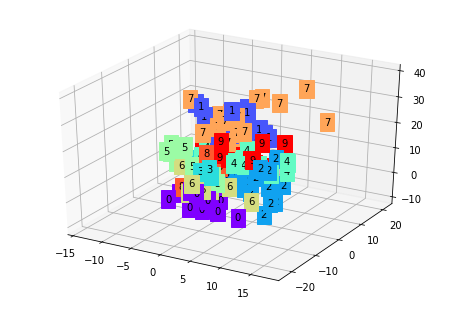

In [12]:
# 可视化
x = codes[:, 0]
y = codes[:, 1]
z = codes[:, 2]

fig = plt.figure()
ax = Axes3D(fig)
for X, Y, Z, S in zip(x, y, z, view_labels):
    c = cm.rainbow(int(255 * S / 9))
    ax.text(X, Y, Z, S, backgroundcolor=c)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_zlim(z.min(), z.max())
plt.show()

可以看到，不同种类的图片进入自动编码器之后会被编码得不同，而相同类型的图片经过自动编码之后的编码在几何示意图上距离较近，在训练好自动编码器之后，我们可以给一个随机的 code，通过 decoder 生成图片

In [13]:
import numpy as np

test_code = np.array([0.0, 0.0, 5.0]).reshape((1, 3))

这里注意到`tensorflow`一个非常有用的技巧, 我们可以给不是定义成占位符的张量当作占位符喂入数据, 比如下面的`code`.

可以通过`tf.Graph.is_feedable()`查看一个张量是否可以被当作占位符使用

In [14]:
# 直接给编码喂入元素, 查看解码结果
decode = sess.run(output, feed_dict={code: test_code})

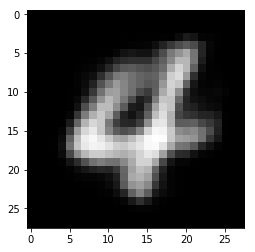

In [15]:
decode = ((decode * 0.5 + 0.5) * 255).reshape((28, 28))
plt.imshow(decode.astype(np.uint8), cmap='gray')

这里我们仅仅使用多层神经网络定义了一个自动编码器，当然你会想到，为什么不使用效果更好的卷积神经网络呢？我们当然可以使用卷积神经网络来定义，下面我们就重新定义一个卷积神经网络来进行 autoencoder

在使用全连接层的时候我们很容易就能够将数据进行上采样, 那么在使用卷积中也有类似功能的操作, 就是[转置卷积](https://github.com/vdumoulin/conv_arithmetic). 我们先直接使用它, 在后面图像分割 的内容中会进行详细的说明

In [16]:
def conv_autoencoder(inputs, scope='conv_autoencoder', reuse=None):
    with tf.variable_scope(scope, reuse=reuse):
        with slim.arg_scope([slim.conv2d, slim.conv2d_transpose], activation_fn=tf.nn.relu, padding='SAME'):
            with tf.variable_scope('encoder'):
                encode = slim.conv2d(inputs, 16, 3, stride=3, scope='conv1') # (b, 10, 10, 16)
                encode = slim.max_pool2d(encode, 2, stride=2, padding='SAME', scope='pool1') # (b, 5, 5, 16)
                encode = slim.conv2d(encode, 8, 3, stride=2, scope='conv2') # (b, 3, 3, 8)
                encode = slim.max_pool2d(encode, 2, stride=2, padding='SAME', scope='pool2') # (b, 2, 2, 8)
            with tf.variable_scope('decoder'):
                decode = slim.conv2d_transpose(encode, 16, 3, stride=2, padding='VALID', scope='trans_conv1') # (b, 5, 5, 16)
                decode = slim.conv2d_transpose(decode, 8, 5, stride=3, scope='trans_conv2') # (b, 15, 15, 8)
                decode = slim.conv2d_transpose(decode, 1, 3, stride=2, activation_fn=None, scope='trans_conv3') # (b, 30, 30, 1)
                decode = tf.image.resize_bilinear(decode, (28, 28)) # (b, 28, 28, 1) 这里由于转置卷积的不可逆, 采用线性插值回到原图大小
                decode = tf.tanh(decode)

            return encode, decode

In [17]:
conv_ph = tf.reshape(input_ph, (-1, 28, 28, 1))
conv_input = tf.divide(conv_ph - 0.5, 0.5)
conv_code, conv_out = conv_autoencoder(conv_input)

In [18]:
loss= tf.losses.mean_squared_error(conv_input, conv_out)
opt = tf.train.AdamOptimizer(1e-3)
train_op = opt.minimize(loss)

同样地, 添加`summary`

In [19]:
pre = conv_out * 0.5 + 0.5
images = tf.concat([conv_ph, pre], axis=2)[:3]
images_sum = tf.summary.image('images', images)

In [20]:
sess.run(tf.global_variables_initializer())

train_writer = tf.summary.FileWriter('conv_autoencoder/train', sess.graph)
val_writer = tf.summary.FileWriter('conv_autoencoder/val', sess.graph)

In [21]:
for e in range(40):
    num_examples = 0
    while num_examples < train_set.num_examples:
        if num_examples + 128 < train_set.num_examples:
            batch = 128
        else:
            batch = train_set.num_examples - num_examples
        num_examples += batch
        train_imgs, _ = train_set.next_batch(batch)
        train_outputs, _ = sess.run([output, train_op], feed_dict={input_ph: train_imgs})
    if (e + 1) % 5 == 0:
        train_imgs_sum, train_loss = sess.run([images_sum, loss], feed_dict={input_ph: train_imgs})
        train_writer.add_summary(train_imgs_sum)
        val_imgs, _ = test_set.next_batch(128)
        val_imgs_sum, val_loss = sess.run([images_sum, loss], feed_dict={input_ph: val_imgs})
        val_writer.add_summary(val_imgs_sum)
        print('Epoch: {}, train_loss: {:.5f}, val_loss: {:.5f}'.format(e + 1, train_loss, val_loss))
train_writer.close()
val_writer.close()

Epoch: 5, train_loss: 0.09759, val_loss: 0.09612
Epoch: 10, train_loss: 0.08677, val_loss: 0.09205
Epoch: 15, train_loss: 0.09432, val_loss: 0.07931
Epoch: 20, train_loss: 0.08556, val_loss: 0.08814
Epoch: 25, train_loss: 0.08657, val_loss: 0.07837
Epoch: 30, train_loss: 0.08831, val_loss: 0.07644
Epoch: 35, train_loss: 0.07682, val_loss: 0.08056
Epoch: 40, train_loss: 0.08056, val_loss: 0.07557


最后我们看看结果

<img src="https://image.ibb.co/bVPn0x/conv_autoencoder.png">

这里我们展示了简单的自动编码器，也用了多层神经网络和卷积神经网络作为例子，但是自动编码器存在一个问题，我们并不能任意生成我们想要的数据，因为我们并不知道 encode 之后的编码到底是什么样的概率分布，所以有一个改进的版本变分自动编码器，其能够解决这个问题